In [126]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import math
from os import listdir
import data_visualization as dv
import pickle
import scipy 
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm 
import random

In [127]:
# Initial thangs
os.chdir('D:\\Subject_Data\\Seth_MatchPennies_Agent_Pilot_v1')
PATH = os.getcwd()
with open(PATH+"\\Analysis_Pull_List.txt","r") as pull_file:
    analysis_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt","r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()  
# SPECIFIC TO EXPERIMENT   
reaction_trials = 50    
timing_trials = 50
num_trials = 80 #number of trials in each block 
num_blocks = 8
tot_trials = num_trials*num_blocks
data_columns = len(fields_pull)
trial_time = 1500
num_subjects = len(analysis_pull_list)
wheel = dv.ColorWheel()

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

In [128]:
#%% Plot properties
box_lw = 2.5 #box linewidth
boxwidth = .07 #box width
whisker_lw = 2.0 #whisker linewidth
circle_size = 8 

tp3_title = "1000,100"
tp4_title = "1000,200"
tp5_title = '1100,100'
tp6_title = "1100,200"
tp7_title = "1200,100"
tp8_title = '1200,200'
tp9_title = '1300,100'
tp10_title = '1300,200'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title, tp9_title,tp10_title]

box_color1 = wheel.dark_blue
box_color2 = wheel.dark_red
box_color3 = '0.4'
#boxprops
two_props = {"facecolor": "none", "edgecolor" : box_color1, "linewidth": box_lw, "alpha": 1}
three_props = {"facecolor": "none", "edgecolor" : box_color2, "linewidth": box_lw, "alpha": 1}
four_props = {"facecolor": "none", "edgecolor" : box_color3, "linewidth": box_lw, "alpha": 1}
#whiskerprops
two_whisk = {"linewidth" : whisker_lw, "color": box_color1}
three_whisk = {"linewidth" : whisker_lw, "color": box_color2}
four_whisk = {"linewidth" : whisker_lw, "color": box_color3}
#capprops
two_cap = {"linewidth" : whisker_lw, "color": box_color1}
three_cap = {"linewidth" : whisker_lw, "color": box_color2}
four_cap = {"linewidth" : whisker_lw, "color": box_color3}
#medianprops
two_median = {"linewidth" : whisker_lw, "color": box_color1}     
three_median = {"linewidth" : whisker_lw, "color": box_color2}   
four_median = {"linewidth" : whisker_lw, "color": box_color3}        
    
#total_indecisions = np.concatenate((perc_player_indecisions,perc_indecisions_R))
props = [{}, {}, {}, {}, {}, {}]
props_dict = {}
box_color = 'grey'

### Functions

In [129]:
def update_params(label_color):
    print('here')
    params = {"ytick.color" : label_color,
              "xtick.color" : label_color,
              "axes.labelcolor" : label_color,
              "axes.edgecolor" : label_color,
              "axes.titlecolor": label_color, 
              'legend.labelcolor': label_color,
              }
    plt.rcParams.update(params)   

In [130]:
def jitter(arr, data):
    if data.ndim >1:
        arr = np.tile(arr,(np.shape(data)[0],1))
        arr = arr + np.random.normal(0,0.05, np.shape(data))
    else:
        arr = arr + np.random.normal(0,0.05, np.shape(data))
    return arr

In [131]:
#%% Box plot with option to make double boxplot
def boxplot(data, xlocs, ylocs, box_widths = 0.15, shift_box = False, shift_direction = 1, 
            legend_labels = None, xlab = None, ylab=None, title=None):
    og_xlocs = xlocs
    box_xlocs = xlocs
    props = [two_props,two_whisk,two_cap,two_median]
    if shift_box:
        box_xlocs = box_xlocs + shift_direction*box_widths*4
        xlocs = xlocs + shift_direction*box_widths*4
        if shift_direction == 1:
            props = [two_props,two_whisk,two_cap,two_median]
        else:
            props = [three_props,three_whisk,three_cap,three_median]

    filtered_data = data
    if np.isnan(data).any():
        mask = ~np.isnan(data)
        filtered_data = [d[m] for d,m in zip(data.T, mask.T)]
    else:
        filtered_data = data
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    ax.boxplot(filtered_data, positions=box_xlocs, patch_artist=True, boxprops = props[0], whiskerprops = props[1], 
                capprops = props[2], medianprops = props[3], showfliers=False, widths = (box_widths)*len(xlocs))
    ax.set_xticks(og_xlocs) 
    #ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    if shift_box:
        colors = [wheel.dark_red,wheel.dark_blue]
        dv.Custom_Legend(ax, legend_labels, colors, fontsize = 10)
        

In [132]:
#%% Scatter plot, two separate data sets on same plot
def two_data_scatter_correlation(data1a, data1b, data2a, data2b, 
                                 xlocs, ylocs, 
                                 xlab, ylab, title, color1, color2, 
                                 savename, save):
    # =============================================================================
    #     Calculate Linear model
    # =============================================================================
    # Combine the two groups ------------------------------------------------
    all_data_a = np.concatenate((data1a,data2a))
    all_data_a = all_data_a.flatten()
    all_data_b = np.concatenate((data1b,data2b))
    all_data_b = all_data_b.flatten()
    
    # Linear model ---------------------------------------------------------------
    
    print(all_data_a)
    print()
    print(all_data_b)
    lm = stats.linregress(all_data_a,all_data_b)
    x = np.arange(min(xlocs)+2,max(xlocs)-10,10)
    y = lm.slope*x + lm.intercept
    spear_r = stats.spearmanr(all_data_a, all_data_b)
    if save:
        label_color = 'w'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    else:
        label_color = 'black'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    plt.figure(dpi = 300, figsize = (6,4))
    xlocs = xlocs
    ylocs = ylocs
    ax = plt.subplot()
    ax.patch.set_alpha(0.05)
    ax.scatter(data1a, data1b, c = color1)
    ax.scatter(data2a, data2b, c = color2)
    ax.plot(x,y,c='grey')
    ax.text(xlocs[2],ylocs[2],r'$\rho$'+f' = {spear_r.correlation:0.3f}')
    ax.text(xlocs[2],ylocs[2]-17,r'p'+f' = {spear_r.pvalue:0.3f}')
    ax.set_xticks(xlocs)
    ax.set_xticklabels(xlocs)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    labels = ["Full Feedback", "Feedback Loss"]
    colors = [wheel.dark_blue, wheel.dark_red]
    dv.Custom_Legend(ax, labels, colors, fontsize = 10)
    plt.tight_layout()
    if save:
        plt.savefig(PATH+'\\Figures\\'+savename, dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()

In [133]:
#%% Scatter plot, one data set 
def one_data_scatter_correlation(data1a, data1b,
                                 xlocs, ylocs, 
                                 xlab, ylab, title, color1, color2, 
                                 savename, save):
    data1_f = data1a.flatten()
    data2_f= data1b.flatten()
    lm = stats.linregress(data1_f,data2_f)
    x = np.arange(min(xlocs)+2,max(xlocs)-10,10)
    y = lm.slope*x + lm.intercept
    spear_r = stats.spearmanr(data1_f, data2_f)
    if save:
        label_color = 'w'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    else:
        label_color = 'black'
        params = {"ytick.color" : label_color,
                  "xtick.color" : label_color,
                  "axes.labelcolor" : label_color,
                  "axes.edgecolor" : label_color,
                  "axes.titlecolor": label_color, 
                  'legend.labelcolor': label_color,
                  }
        plt.rcParams.update(params)
    plt.figure(dpi = 300, figsize = (6,4))
    xlocs = xlocs
    ylocs = ylocs
    ax = plt.subplot()
    ax.patch.set_alpha(0.05)
    ax.scatter(data1a, data1b, c = color1)
    ax.plot(x,y,c='grey')
    ax.text(xlocs[2],ylocs[2],r'$\rho$'+f' = {spear_r.correlation:0.3f}')
    ax.text(xlocs[2],ylocs[2]-17,r'p'+f' = {spear_r.pvalue:0.3f}')
    ax.set_xticks(xlocs)
    ax.set_xticklabels(xlocs)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    labels = ["Full Feedback", "Feedback Loss"]
    colors = [wheel.dark_blue, wheel.dark_red]
    #dv.Custom_Legend(ax, labels, colors, fontsize = 10)
    plt.tight_layout()
    if save:
        plt.savefig(PATH+'\\Figures\\'+savename, dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()

### Pickle

In [142]:
#%% Pickle load 
player_wins = np.zeros((num_subjects, num_blocks))
player_indecisions = np.zeros((num_subjects, num_blocks))
perc_player_wins = np.zeros((num_subjects, num_blocks))
perc_player_indecisions = np.zeros((num_subjects, num_blocks))
trial_table = np.empty((num_subjects, tot_trials, 4), int)
player_reach_time = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
player_decision_array = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
reaction_time = np.zeros([num_subjects,reaction_trials])*np.nan 
reaction_movement_time = np.zeros([num_subjects,reaction_trials])*np.nan 
rt_trial_start = np.zeros((num_subjects,reaction_trials))*np.nan 
timing_reach_time = np.zeros([num_subjects,reaction_trials])*np.nan 
hand_pos_data = np.zeros((num_subjects, num_blocks, num_trials, trial_time+500, 4))*np.nan
agent_reach_time = np.zeros((num_subjects,num_blocks,num_trials))
agent_target_selection = np.zeros((num_subjects,num_blocks,num_trials))
player_incorrect_decisions = np.zeros((num_subjects,num_blocks))
player_left_start_time = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 

for i in range(num_subjects):
    subname = analysis_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_player_indecisions.pkl', 'rb'))
    player_wins[i,:] = pickle.load(open(data_path + f'{subname}_player_wins.pkl', 'rb'))
    perc_player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions.pkl', 'rb'))
    perc_player_wins[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins.pkl', 'rb'))
    #trial_table[i,:,:] = pickle.load(open(data_path + f'{subname}_trial_table.pkl', 'rb'))
    player_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_reach_time.pkl', 'rb'))
    hand_pos_data[i,:,:,:,:] = pickle.load(open(data_path+f'{subname}_hand_pos_data.pkl', 'rb'))
    reaction_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_time.pkl', 'rb'))
    reaction_movement_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_movement_time.pkl', 'rb'))
    rt_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_rt_trial_start.pkl', 'rb'))
    timing_reach_time[i,:] = pickle.load(open(data_path + f'{subname}_timing_reach_time.pkl', 'rb'))
    agent_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_reach_time.pkl', 'rb'))
    agent_target_selection[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_target_selection.pkl', 'rb'))
    player_incorrect_decisions[i,:] = pickle.load(open(data_path + f'{subname}_player_incorrect_decisions.pkl', 'rb'))
    player_left_start_time[i,:] = pickle.load(open(data_path + f'{subname}_player_left_start_time.pkl', 'rb'))
    player_decision_array[i,:] = pickle.load(open(data_path + f'{subname}_player_decision_array.pkl', 'rb'))
agent_left_start_time = agent_reach_time - 300
perc_player_incorrect_decisions = player_incorrect_decisions/80*100

### Calculations

Reaction and Reaction Movement Time

In [143]:
#%% Calculate RT means and sds
rt_mean = np.zeros(num_subjects)
rt_sd = np.zeros(num_subjects)
rmt_mean = np.zeros(num_subjects)
rmt_sd = np.zeros(num_subjects)

# Reaction time
for i in range(num_subjects):
    rt_mean[i] = np.mean(reaction_time[i,25:])
    rt_sd[i] = np.std(reaction_time[i,25:])
    rmt_mean[i] = np.mean(reaction_movement_time[i,25:])
    rmt_sd[i] = np.std(reaction_movement_time[i,25:])


Experiment reach and decision times

In [144]:
# Actual trials
agent_mean_reach_time = np.nanmean(agent_reach_time,axis = 2)
agent_sd_reach_time = np.nanstd(agent_reach_time,axis = 2)
agent_mean_decision_time = np.nanmean(agent_left_start_time, axis =2)
agent_sd_decision_time = np.nanstd(agent_left_start_time, axis =2)
player_mean_reach_time = np.nanmean(player_reach_time,axis=2)
player_sd_reach_time = np.nanstd(player_reach_time,axis=2)
player_mean_decision_time = np.nanmean(player_left_start_time,axis=2)
player_sd_decision_time = np.nanstd(agent_reach_time,axis = 2)

Reach Times on Indecisions

In [145]:
#%% Find agent reach times for player indecisions
agent_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
player_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
player_left_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_mean_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
player_mean_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
player_mean_left_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
indecision_index = np.argwhere(player_reach_time>1500)

c=0
for i,j,k in indecision_index:
    agent_reach_time_on_indecisions[i,j,k] = agent_reach_time[i,j,k]
    player_reach_time_on_indecisions[i,j,k] = player_reach_time[i,j,k]
    player_left_time_on_indecisions[i,j,k] = player_left_start_time[i,j,k]
    c+=1
for i in range(num_subjects):
    for j in range(num_blocks):
        agent_mean_reach_time_on_indecisions[i,j] = np.nanmean(agent_reach_time_on_indecisions[i,j,:])
        player_mean_reach_time_on_indecisions[i,j] = np.nanmean(player_reach_time_on_indecisions[i,j,:])
        player_mean_left_time_on_indecisions[i,j] = np.nanmean(player_left_time_on_indecisions[i,j,:])

agent_mean_left_time_on_indecisions = agent_mean_reach_time_on_indecisions - 300

C:\Users\SETHSU~1\AppData\Local\Temp/ipykernel_63652/731202839.py:18: RuntimeWarning: Mean of empty slice
  agent_mean_reach_time_on_indecisions[i,j] = np.nanmean(agent_reach_time_on_indecisions[i,j,:])
C:\Users\SETHSU~1\AppData\Local\Temp/ipykernel_63652/731202839.py:19: RuntimeWarning: Mean of empty slice
  player_mean_reach_time_on_indecisions[i,j] = np.nanmean(player_reach_time_on_indecisions[i,j,:])
C:\Users\SETHSU~1\AppData\Local\Temp/ipykernel_63652/731202839.py:20: RuntimeWarning: Mean of empty slice
  player_mean_left_time_on_indecisions[i,j] = np.nanmean(player_left_time_on_indecisions[i,j,:])


Gamble and reaction calculations

In [146]:
# Go through gamble reach times and then wins, indecisions, losses separately for reaction and gambles
#%% Average agent mean reach time on gamb

gamble_left_target_time = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
gamble_reach_target_time = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_reach_time_gambles = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_left_time_gambles = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
gamble_index = np.argwhere(abs(agent_left_start_time-player_left_start_time)<250)
for i,j,k in gamble_index:
    gamble_left_target_time[i,j,k] = player_left_start_time[i,j,k]
    gamble_reach_target_time[i,j,k] = player_reach_time[i,j,k]
    agent_reach_time_gambles[i,j,k] = agent_reach_time[i,j,k]
    agent_left_time_gambles[i,j,k] = agent_reach_time[i,j,k] - 300

#%% Count wins where they gambled, wins where they reacted, losses when they gambled, losses when they reacted, and indecisions
## 200 is probably too small for two choice reaction 
gamble_index = np.argwhere(player_left_start_time-agent_left_start_time<250)
reaction_index = np.argwhere((player_left_start_time-agent_left_start_time>=250))
did_not_leave_start_index = np.argwhere((np.isnan(player_left_start_time))) # This indiddex is for if they left the start too early, or didn't leave at all

#left_out = np.argwhere()
gamble_wins = np.zeros((num_subjects, num_blocks))
gamble_indecisions = np.zeros((num_subjects, num_blocks))
gamble_losses = np.zeros((num_subjects, num_blocks))
reaction_wins = np.zeros((num_subjects, num_blocks))
reaction_indecisions = np.zeros((num_subjects, num_blocks))
reaction_losses = np.zeros((num_subjects, num_blocks))
for i,j,k in gamble_index:
    if player_decision_array[i,j,k] == 1 and (agent_target_selection[i,j,k] == 1 or agent_target_selection[i,j,k] == 0):
        gamble_wins[i,j] += 1
    elif player_decision_array[i,j,k] == -1 and (agent_target_selection[i,j,k] == -1 or agent_target_selection[i,j,k] == 0):
        gamble_wins[i,j] += 1
    elif player_decision_array[i,j,k] == 0:
        gamble_indecisions[i,j] += 1
    elif player_decision_array[i,j,k]*agent_target_selection[i,j,k] == -1:
        gamble_losses[i,j] += 1
    else:
        print('none')
    
  
for i,j,k in reaction_index:
    if player_decision_array[i,j,k] ==  1 and (agent_target_selection[i,j,k] == 1 or agent_target_selection[i,j,k] == 0):
        reaction_wins[i,j] += 1
    elif player_decision_array[i,j,k] == -1 and (agent_target_selection[i,j,k] == -1 or agent_target_selection[i,j,k] == 0):
        reaction_wins[i,j] += 1
    elif player_decision_array[i,j,k] == 0:
        reaction_indecisions[i,j] += 1
    elif player_decision_array[i,j,k]*agent_target_selection[i,j,k] == -1:
        reaction_losses[i,j] += 1
    else:
        print("none triggerd")
for i,j,k in did_not_leave_start_index:
    if player_decision_array[i,j,k] == 0:
        reaction_indecisions[i,j]+=1 # If they ended up not mkaing it, it was likely due to reaction indecision
    #lif player_decision_array[i,j,k]*agent_target_selection[i,j,k]>0:
       
perc_gamble_wins = gamble_wins/num_trials*100
perc_gamble_losses = gamble_indecisions/num_trials*100
perc_gamble_indecisions = gamble_losses/num_trials*100
perc_reaction_wins = reaction_wins/num_trials*100
perc_reaction_losses = reaction_losses/num_trials*100
perc_reaction_indecisions = reaction_indecisions/num_trials*100


In [147]:
# Calculate the average reach time for each subject when they gamble for each condition 
gamble_index = np.argwhere(player_left_start_time-agent_left_start_time<200)
reaction_index = np.argwhere((player_left_start_time-agent_left_start_time>=200))
did_not_leave_start_index = np.argwhere((np.isnan(player_left_start_time)))
gamble_decision_times = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
reaction_decision_times = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
for i,j,k in gamble_index:
    gamble_decision_times[i,j,k] = player_left_start_time[i,j,k]
for i,j,k in reaction_index:
    reaction_decision_times[i,j,k] = player_left_start_time[i,j,k]
    
# get means
gamble_decision_time_means = np.nanmean(gamble_decision_times, axis =2 )
reaction_decision_time_means = np.nanmean(reaction_decision_times, axis =2 )

C:\Users\SETHSU~1\AppData\Local\Temp/ipykernel_63652/2048409299.py:14: RuntimeWarning: Mean of empty slice
  reaction_decision_time_means = np.nanmean(reaction_decision_times, axis =2 )


### Plots

Reaction time boxplot

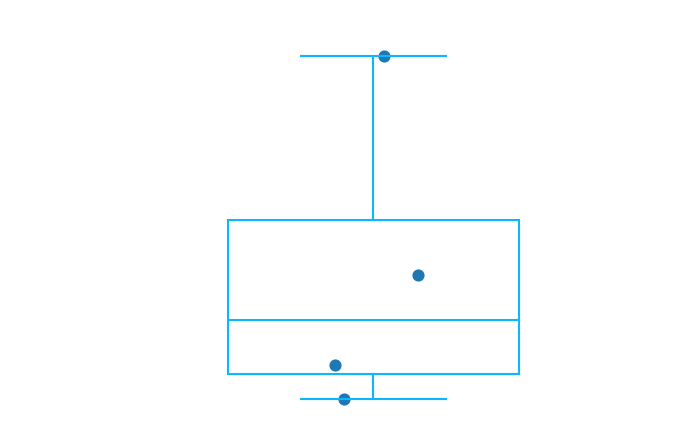

In [148]:
fig,ax = plt.subplots(dpi=125)
xlocs = [0]*num_subjects
ylocs = np.arange(200,400,25)
ax.scatter(jitter(xlocs, rt_mean), rt_mean)
bp3 = dv.boxplot(rt_mean, ax=ax, x_pos = 0)
ax.set_ylabel('Time (ms)')
ax.set_title('Reaction Times')
ax.xaxis.set_ticklabels([])
ax.get_xaxis().set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)


Decision Times boxplot

In [149]:
dot_color = 'black'

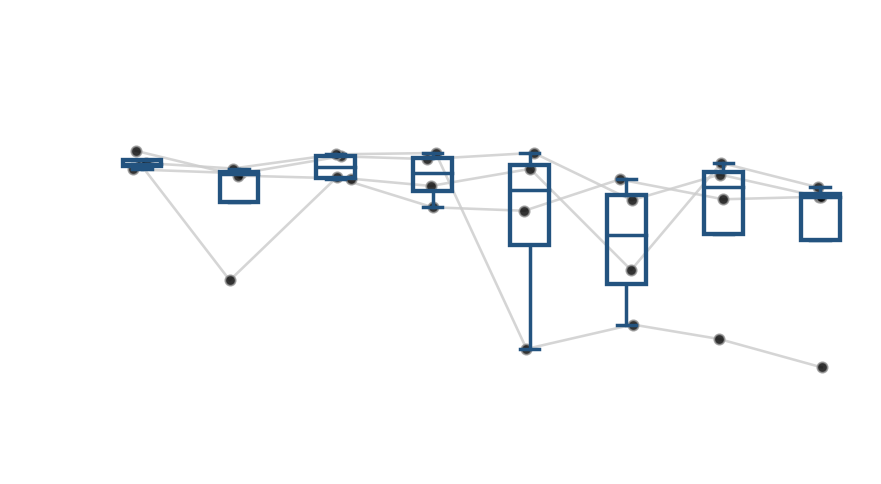

In [150]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(400,1800,200)
plt.figure(dpi=125, figsize = (8,4))
ax=plt.subplot()
boxplot(player_mean_decision_time, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean Decision Time (ms)",
        ylab='Time (ms)', title='Decision Times')
ax.plot(jitter(xlocs, player_mean_decision_time).T,player_mean_decision_time.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.8', alpha = 0.8,zorder=1 )
ax.set_ylim(400,1600)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(PATH+'\\Figures\\'+'decision_times_boxplots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Reach Times boxplot

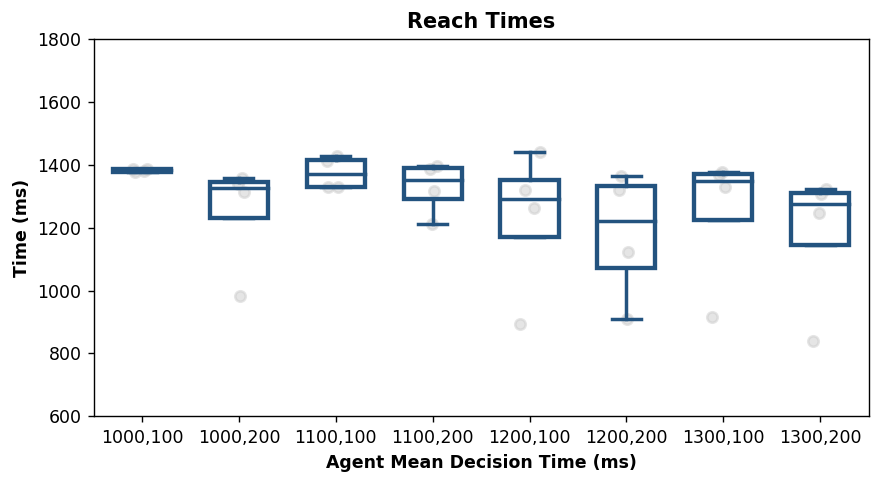

In [58]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(600,2000,200)
plt.figure(dpi=125, figsize = (8,4))
ax=plt.subplot()
boxplot(player_mean_reach_time,xlocs, ylocs, xlab = "Agent Mean Decision Time (ms)",
        ylab='Time (ms)', title='Reach Times',
        savename='wins_all_subs',save=False)

Indecisions, Wins, Wrong Decisions

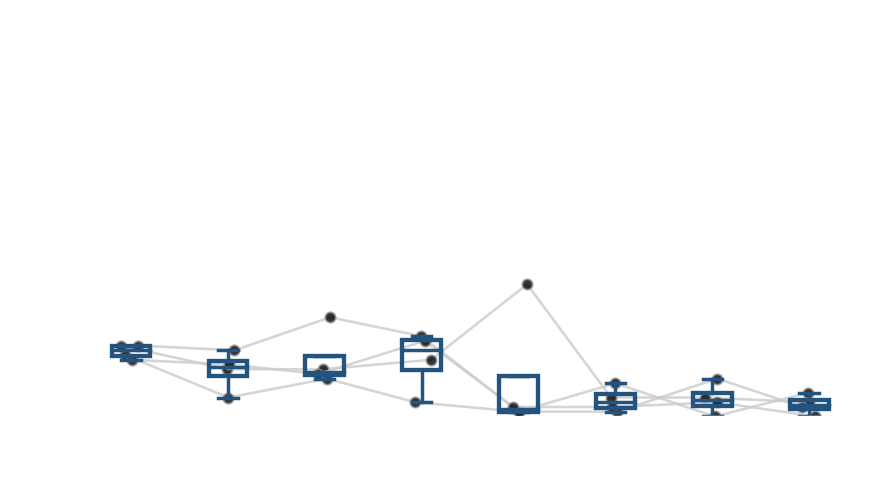

In [151]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi=125, figsize=(8,4))
ax=plt.subplot()
boxplot(perc_player_indecisions, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean Decision Time (ms)",
        ylab='Indecisions (%)', title='Indecisions')
ax.plot(jitter(xlocs, perc_player_indecisions).T,perc_player_indecisions.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.8', alpha = 0.8,zorder=1 )
ax.set_ylim(0,100)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(PATH+'\\Figures\\'+'indecisions_boxplots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

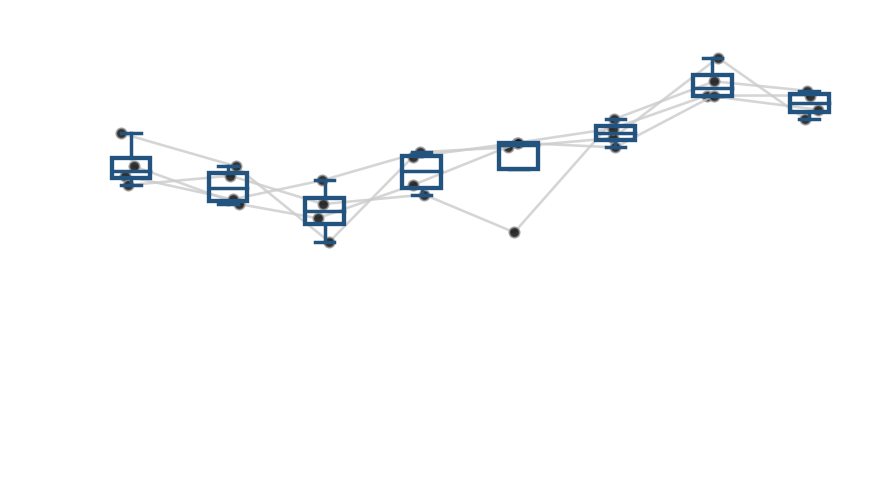

In [152]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi=125, figsize=(8,4))
ax=plt.subplot()
boxplot(perc_player_wins, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean Decision Time (ms)",
        ylab='Wins (%)', title='Wins')
ax.plot(jitter(xlocs, perc_player_wins).T,perc_player_wins.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.8', alpha = 0.8,zorder=1 )
ax.set_ylim(0,100)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(PATH+'\\Figures\\'+'wins_boxplots', dpi = 400, transparent = True, bbox_inches='tight')

plt.show()

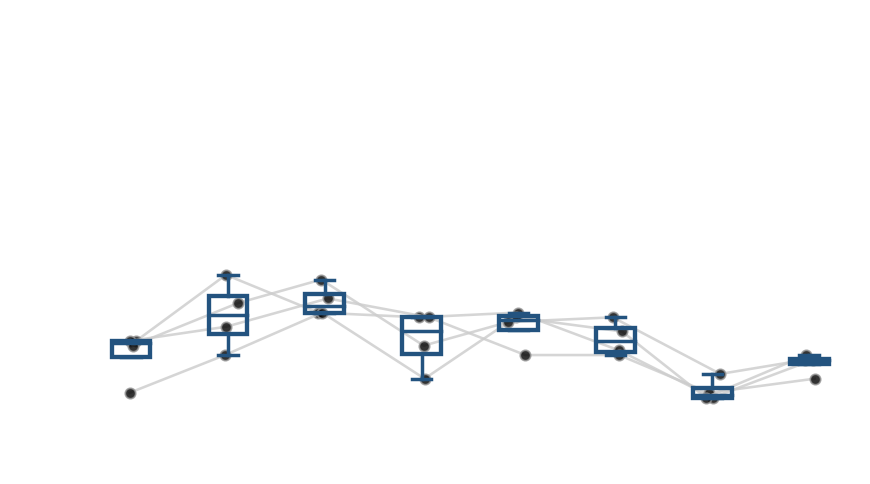

In [153]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi=125, figsize=(8,4))
ax=plt.subplot()
boxplot(perc_player_incorrect_decisions, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean Decision Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
ax.plot(jitter(xlocs, perc_player_incorrect_decisions).T,perc_player_incorrect_decisions.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.8', alpha = 0.8,zorder=1 )
ax.set_ylim(0,100)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(PATH+'\\Figures\\'+'incorrect_decisions_boxplots', dpi = 400, transparent = True, bbox_inches='tight')

plt.show()

back here

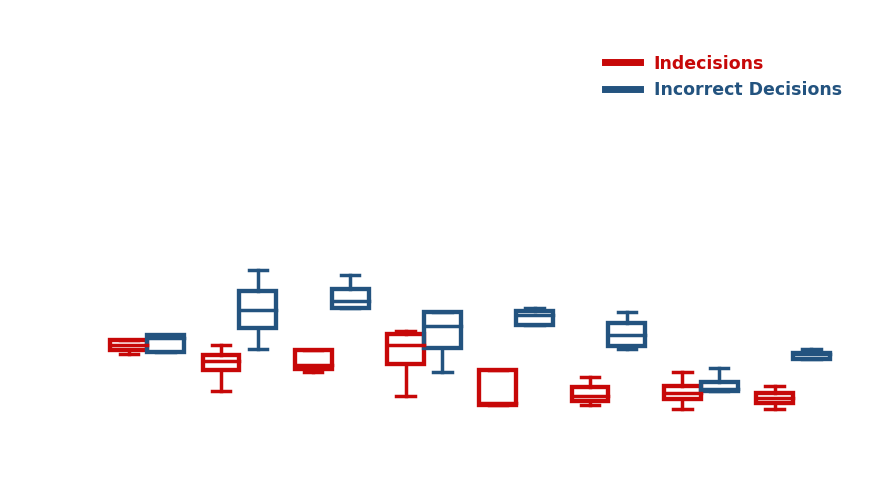

In [154]:
#%% Incorrect decisions and indecisions boxplot together
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,110,25)
box_width = 0.05
plt.figure(dpi=125, figsize=(8,4))
ax=plt.subplot()
boxplot(perc_player_indecisions, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Indecisions', "Incorrect Decisions"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
boxplot(perc_player_incorrect_decisions, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Indecisions', "Incorrect Decisions"],xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(PATH+'\\Figures\\'+'indecisions_incorrect_decisions_boxplots', dpi = 400, transparent = True, bbox_inches='tight')

plt.show()

Gamble decision means boxplot

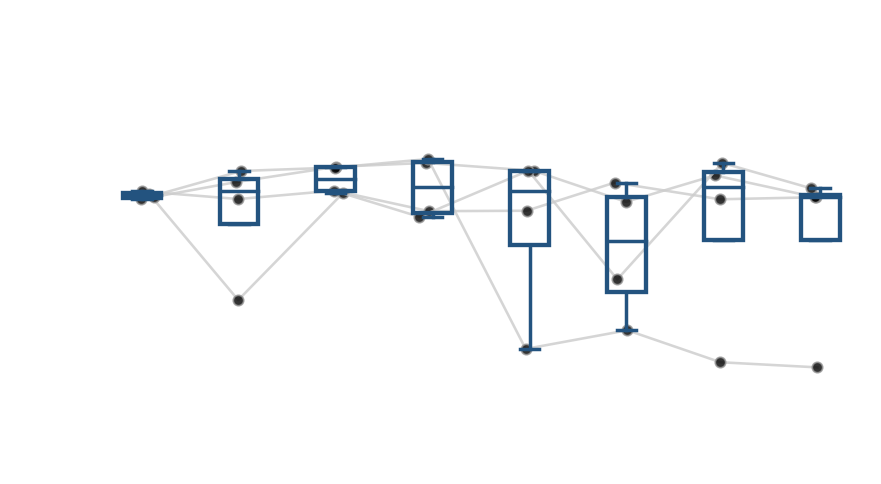

In [155]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(400,1600,200)
plt.figure(dpi=125, figsize=(8,4))
ax=plt.subplot()
boxplot(gamble_decision_time_means, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean Decision Time (ms)",
        ylab='Time (ms)', title='Gamble Decision Time Means')
ax.plot(jitter(xlocs, gamble_decision_time_means).T,gamble_decision_time_means.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.8', alpha = 0.8,zorder=1 )
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(400,1600)
plt.savefig(PATH+'\\Figures\\'+'gamble_decision_means_boxplots', dpi = 400, transparent = True, bbox_inches='tight')

plt.show()

Reaction decision means boxplot

In [67]:
np.shape(gamble_decision_time_means)

(4, 8)

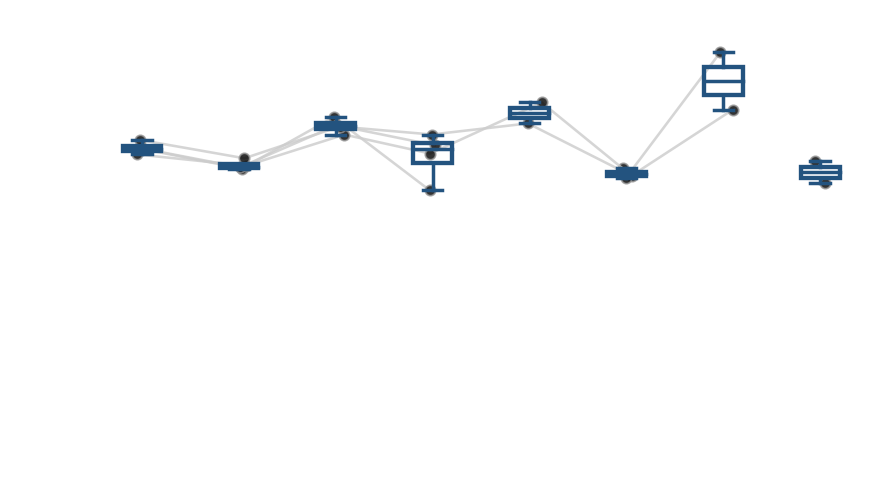

In [156]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(400,1800,200)
plt.figure(dpi=125, figsize=(8,4))
ax=plt.subplot()
boxplot(reaction_decision_time_means, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean Decision Time (ms)",
        ylab='Time (ms)', title='Reaction Decision Time Means')
ax.plot(jitter(xlocs, reaction_decision_time_means).T,reaction_decision_time_means.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.8', alpha = 0.8,zorder=1 )
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(400,1600)
plt.savefig(PATH+'\\Figures\\'+'reaction_decision_means_boxplots', dpi = 400, transparent = True, bbox_inches='tight')

plt.show()

Reaction and gamble together

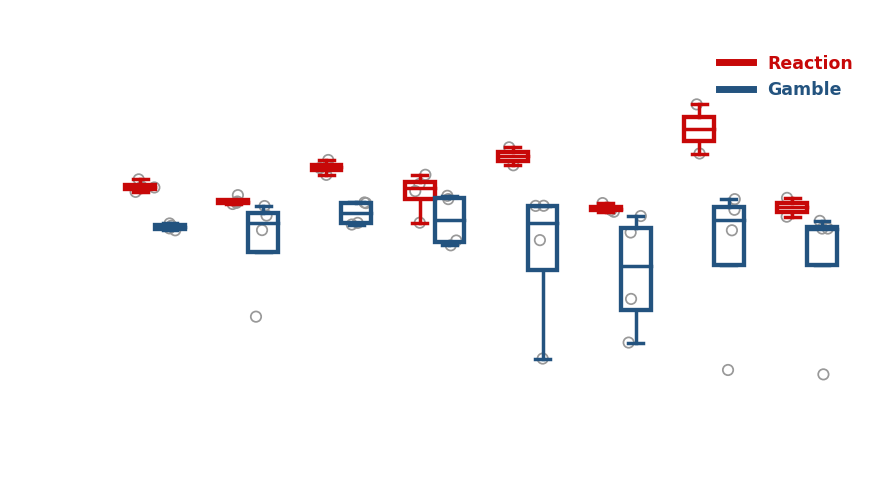

In [157]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(400,2000,200)
box_width = 0.04
plt.figure(dpi=125, figsize=(8,4))
ax=plt.subplot()
boxplot(reaction_decision_time_means, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
ax.scatter(jitter((xlocs-box_width*4), reaction_decision_time_means),reaction_decision_time_means, facecolor = 'none', edgecolors='0.6' )

boxplot(gamble_decision_time_means, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"],xlab = "Agent Mean Decision Time (ms)",
        ylab='Time (ms)', title='Reaction and Gamble Decision Times')
ax.scatter(jitter((xlocs+box_width*4), gamble_decision_time_means),gamble_decision_time_means, facecolor = 'none', edgecolors='0.6' )
ax.set_ylim(400,1800)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
plt.savefig(PATH+'\\Figures\\'+'reaction_and_gamble_decision_times_boxplots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Difference in agent and player decision times boxplot

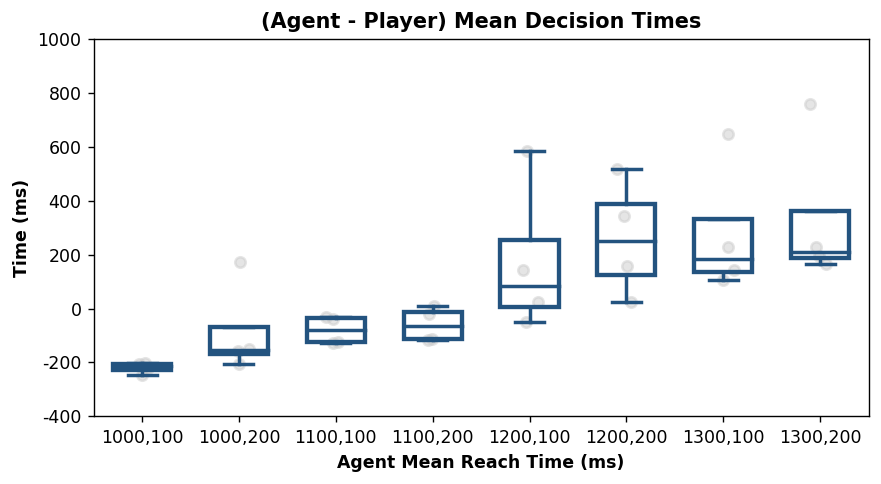

In [219]:
#%% Average difference in agent target left time and player target left time for each condition 
# It's not so much the average reach time that matters as much as the difference between the agent and the player
# This is an indicator of gambling for each state
mean_diff_decision_time = agent_mean_decision_time - player_mean_decision_time
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(-400,1200,200)
plt.figure(dpi = 125, figsize = (8,4))
ax = plt.subplot()
boxplot(mean_diff_decision_time,xlocs = xlocs, ylocs = ylocs, xlab = "Agent Mean Reach Time (ms)",
        ylab='Time (ms)', title='(Agent - Player) Mean Decision Times',
        savename='wins_all_subs',save=False)
plt.show()

Binning agent reach times

In [74]:
#%% Bin agent left start times into 100ms chunks
# Find pLaer left start time and find mean for each of the chunks
# Compare across conditions
bins = np.arange(400,2200,200)
binned_player_decision_times = np.zeros((num_blocks,len(bins),80))*np.nan 

for b in range(len(bins)-1):
    bin_index = np.argwhere((bins[b] < agent_left_start_time) & (agent_left_start_time < bins[b+1]))# and agent_left_start_time < bins[b+1])
    c=-1
    for i,j,k in bin_index:
        c+=1
        binned_player_decision_times[j,b,k] = player_left_start_time[i,j,k] 
mean_of_each_condition_each_bin = np.zeros((num_blocks, len(bins)-1))
for a in range(num_blocks):
    for b in range(len(bins)-1):
        mean_of_each_condition_each_bin[a,b] = np.nanmean(binned_player_decision_times[a,b,:])

C:\Users\SETHSU~1\AppData\Local\Temp/ipykernel_63652/2213818978.py:16: RuntimeWarning: Mean of empty slice
  mean_of_each_condition_each_bin[a,b] = np.nanmean(binned_player_decision_times[a,b,:])


here


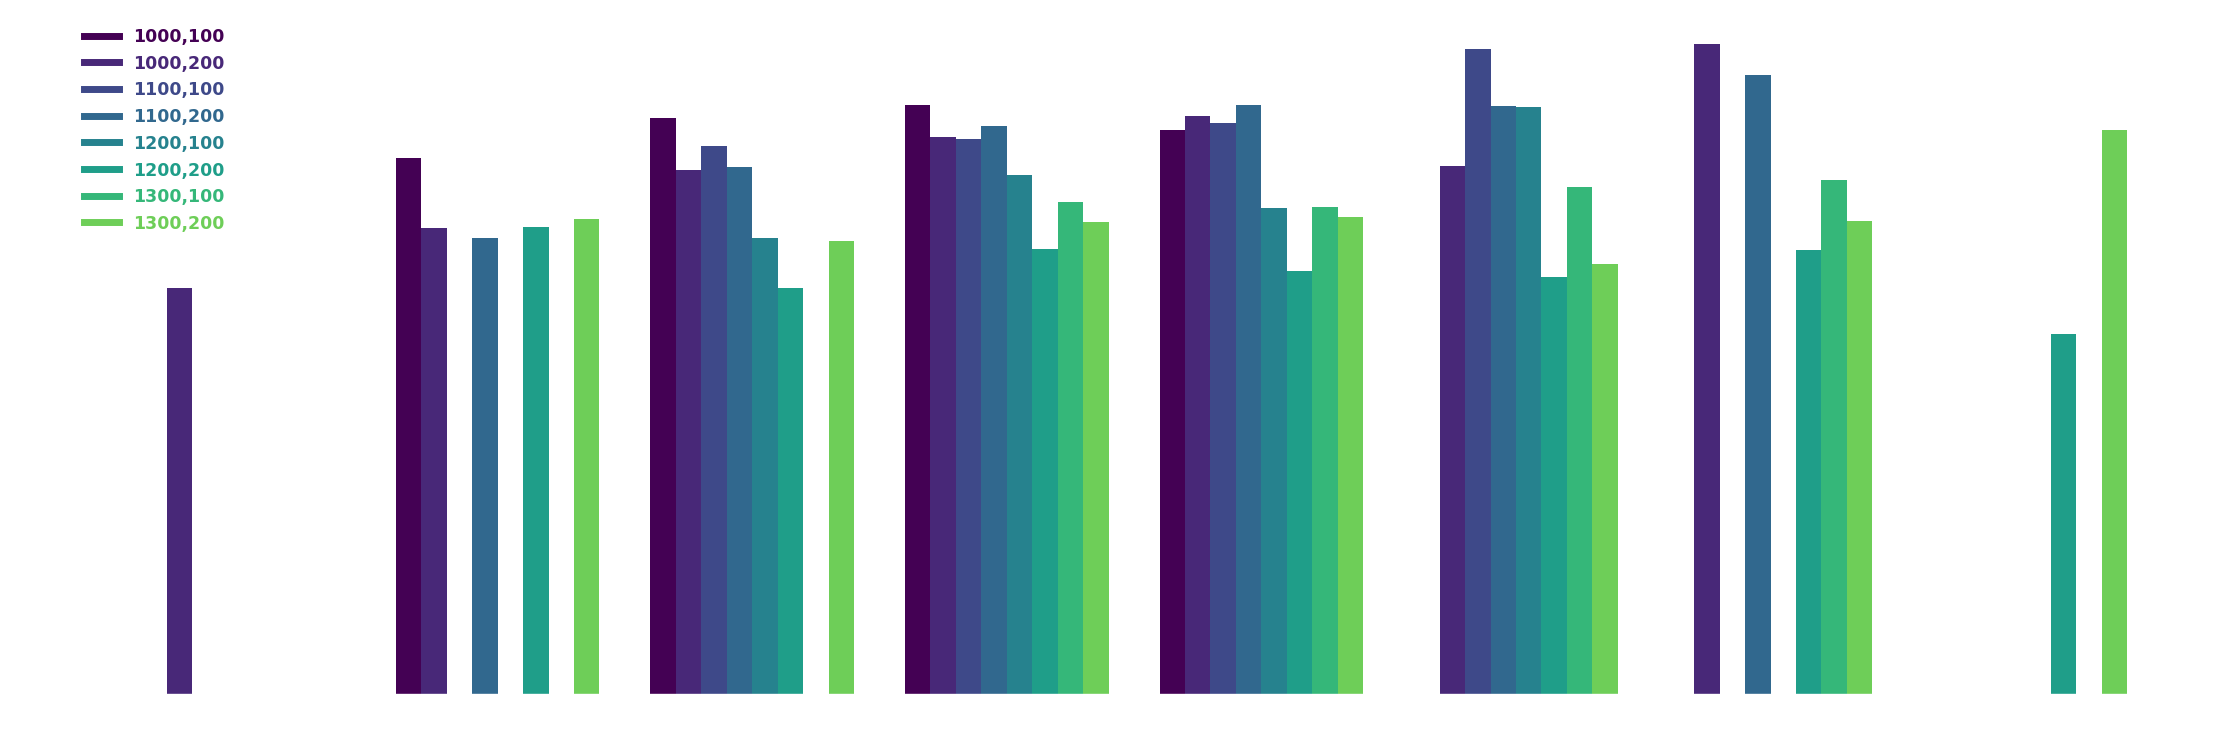

In [123]:
#%% Plot the above
xticklabs = []
for i in range(len(bins)-1):
    xticklabs.append(f'{bins[i]}-{bins[i+1]}') 
xlocs = np.arange(len(bins)-1)
width = 0.1
cdict = {'red':   ((0.0,  0.22, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  0.89, 1.0)),

         'green': ((0.0,  0.49, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  0.12, 1.0)),

         'blue':  ((0.0,  0.72, 0.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  0.11, 1.0))}

color = plt.cm.viridis(np.linspace(0, 1, 10))
plt.figure(dpi = 125, figsize = (18,6))
update_params('w')
ax = plt.subplot()
ax.bar(xlocs - width*3.5, mean_of_each_condition_each_bin[0,:], width=width, color=color[0])
ax.bar(xlocs - width*2.5, mean_of_each_condition_each_bin[1,:], width=width, color=color[1])
ax.bar(xlocs - width*1.5, mean_of_each_condition_each_bin[2,:], width=width, color=color[2])
ax.bar(xlocs - width*1/2, mean_of_each_condition_each_bin[3,:], width=width, color=color[3])
ax.bar(xlocs + width*1/2, mean_of_each_condition_each_bin[4,:], width=width, color=color[4])
ax.bar(xlocs + width*1.5, mean_of_each_condition_each_bin[5,:], width=width, color=color[5])
ax.bar(xlocs + width*2.5, mean_of_each_condition_each_bin[6,:], width=width, color=color[6])
ax.bar(xlocs + width*3.5, mean_of_each_condition_each_bin[7,:], width=width, color=color[7])

ax.set_xticks(xlocs)
ax.set_xticklabels(xticklabs)
labels = trial_block_titles

dv.Custom_Legend(ax, labels, color[:8], fontsize = 10, loc='upper left')
plt.tight_layout()
plt.savefig(PATH+'\\Figures\\'+'binned_reach_times', dpi = 400, transparent = True, bbox_inches='tight')